In [1]:
import numpy as np
import pandas as pd
import os
import random
from keras.layers import Conv2D,Dense, MaxPool2D,Dropout,Flatten
import tensorflow_datasets as tfds
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications import vgg19
from keras.optimizers import Adam
import keras
import tensorflow as tf

In [22]:
train,test=tfds.load("stanford_dogs",split=["train[:75%]","train[75%:]"],shuffle_files=True)

In [3]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=120, activation='softmax'))

In [4]:
model.compile(optimizer=Adam(learning_rate=0.01),loss=keras.losses.categorical_crossentropy,metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [23]:
batch_size=32
num_epochs=100
def preprocess_data(data):
    image = tf.image.resize(data['image'], (224, 224))  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image
    label = tf.one_hot(data['label'], depth=120)  # One-hot encode labels
    return image, label

# Apply preprocessing and batch the data
train_data = train.map(preprocess_data).batch(batch_size)
test_data = test.map(preprocess_data).batch(batch_size)



print(len(train_data))


282


In [7]:
from keras.applications.resnet50 import ResNet50

In [8]:
m=ResNet50(weights="imagenet",include_top=False)

In [25]:
# Load the ResNet50 model with pre-trained weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in resnet_model.layers:
    layer.trainable = False    ## This is the fix

# Create a Sequential model
model = Sequential()

# Add the ResNet50 model to the Sequential model
model.add(resnet_model)

# Flatten the output of the ResNet50 model
model.add(Flatten())

# Add a Dense output layer with softmax activation for classification
model.add(Dense(units=120, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(train_data, epochs=50, validation_data=test_data)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 120)               12042360  
                                                                 
Total params: 35630072 (135.92 MB)
Trainable params: 12042360 (45.94 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/50
282/282 [==============================] - 40s 128ms/step - loss: 16.5059 - accuracy: 0.0144 - val_loss: 10.5339 - val_accuracy: 0.0173
Epoch 2/50
282/282 [==============================] - 37s 130ms/step - loss: 10.2371 - accuracy: 0.0424 - val_loss: 10.469

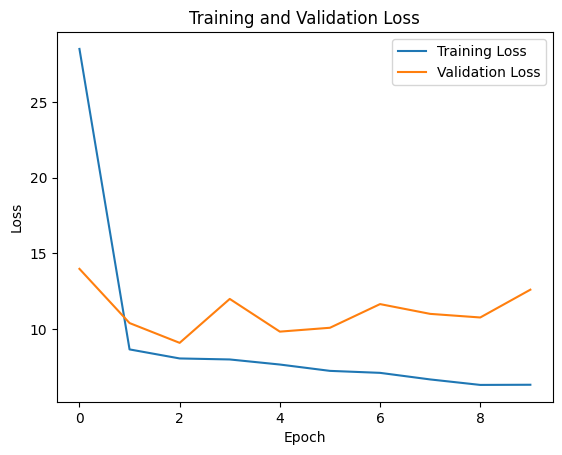

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in resnet_model.layers[:-10]:  # Unfreeze the last 10 layers for fine-tuning
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the ResNet50 model to the Sequential model
model.add(resnet_model)

# Flatten the output of the ResNet50 model
model.add(Flatten())

# Add a Dense output layer with softmax activation for classification
model.add(Dense(units=120, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model with learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = model.fit(train_data, epochs=20, validation_data=test_data, callbacks=[reduce_lr])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 120)               12042360  
                                                                 
Total params: 35630072 (135.92 MB)
Trainable params: 16508024 (62.97 MB)
Non-trainable params: 19122048 (72.94 MB)
_________________________________________________________________
Epoch 1/20
94/94 [==============================] - 87s 557ms/step - loss: 9.7054 - accuracy: 0.0063 - val_loss: 11.7712 - val_accuracy: 0.0086 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - 51s 549ms/step - loss: 5.7127 - accuracy: 0.0383 - val_loss:

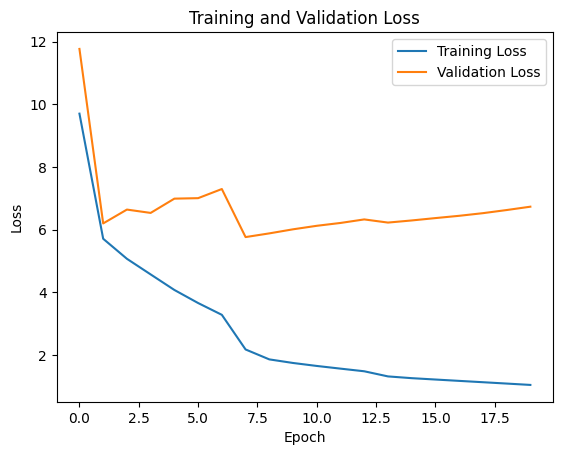

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
predictions = model.predict(test_data)


predicted_class = np.argmax(predictions[0])


predicted_probability_class_0 = predictions[0][0]

print(predicted_class)


282/282 [==============================] - 25s 87ms/step
56


In [21]:
import matplotlib.pyplot as plt

# Get a subset of test data
subset_size = int(0.15 * len(test_data))
subset_test_data = test_data.take(subset_size)

# Iterate over batches of test data
for batch_images, batch_labels in subset_test_data:
    # Make predictions for the batch
    batch_predictions = model.predict(batch_images)

    # Iterate over individual samples in the batch
    for i in range(len(batch_labels)):
        # Get the predicted class label for the sample
        predicted_class = np.argmax(batch_predictions[i])

        # Get the actual class label for the sample
        actual_class = np.argmax(batch_labels[i])

        # Check if the predicted label matches the actual label
        if predicted_class == actual_class:
            prediction_status = "Correct"
        else:
            prediction_status = "Incorrect"

        # Get the original and predicted class names
        original_name = class_names[actual_class]  # Assuming you have a list of class names
        predicted_name = class_names[predicted_class]

        # Plot the actual and predicted images
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(batch_images[i])
        plt.title(f"Actual: {original_name}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(batch_images[i])
        plt.title(f"Predicted: {predicted_name}\nStatus: {prediction_status}")
        plt.axis('off')

        plt.show()


1/1 [==============================] - 0s 145ms/step


NameError: name 'class_names' is not defined